In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy2
import gensim

from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer 

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

# Часть 1
## Исследование данных

In [5]:
# если взять перивый миллион текстов, распределение почти не изменится
df_train = pd.read_csv("./data/task7/train.csv", nrows = 1_000_000)
df_train

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
...,...,...
999995,"E eu disse , de jeito nenhum , não vou estudar...",pt-br
999996,Så hvis du er liberal vil du sige . &quot; &qu...,da
999997,Я почав свою подорож 30 років тому .,uk
999998,数学的に表現するとこうなります もしあなたが 今日の社会を憂慮しているなら 数学的な関数の値...,ja


<BarContainer object of 59 artists>

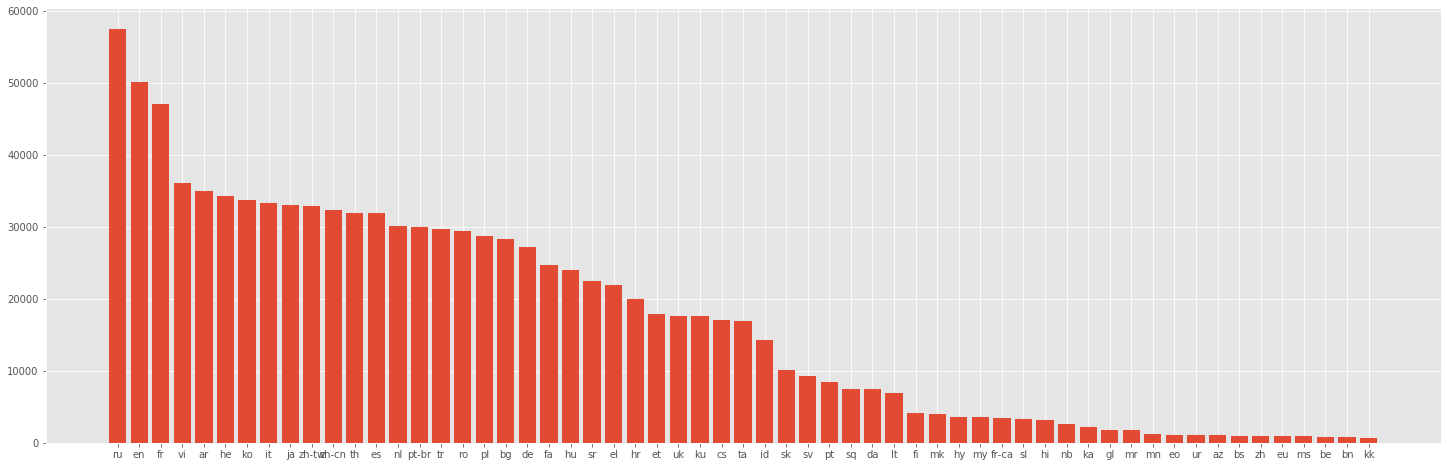

In [6]:
lang_count = (
    df_train.language.value_counts()
    .to_frame()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(25,8))
ax.bar(lang_count['index'], lang_count['language'])

### Ошибки в разметке
Если вывести толко русские тексты, то сразу видно, что в разметке есть ошибки.

In [4]:
df_train[df_train['language'] == 'ru']

,sentence,language
10,После увольнения я решил собрать своих друзей ...,ru
13,"Ты знаешь , что это не гнев заставил моё сердц...",ru
26,гэта што калі мы не яны як але ён каб дзякуй б...,ru
40,"Ради всех имён , которые я никогда не узнаю , ...",ru
91,що це тому ми чи дуже які щоб дякую якщо було ...,ru
...,...,...
999902,гэта што калі мы не яны як але ён каб дзякуй б...,ru
999960,гэта што калі мы не яны як але ён каб дзякуй б...,ru
999979,Каждый Рейнджер обещает другому Рейнджеру Не в...,ru
999981,"Ну конечно , меня интересовала только математи...",ru


Аналогично, если вывести число повторений текстов, можно сразу найти ошибки в других языках:

Белорусский текст

In [127]:
be_text = df_train['sentence'][26]
be_text

'гэта што калі мы не яны як але ён каб дзякуй больш пра на вы'

Украинский текст

In [128]:
uk_text = df_train['sentence'][91]
uk_text

'що це тому ми чи дуже які щоб дякую якщо було вона від мене ось'

In [7]:
#for leng in set(df_train['language']):
#    print(leng)
#    print(df_train[df_train['language'] == leng]['sentence'].value_counts()[:5])
#    print()

# 'et','fr','vi','ru','en','th', 'ta'
errors = ['що це ми не як на вони та але ви до про він оплески коли',
          'що це тому ми чи дуже які щоб дякую якщо було вона від мене ось', 
          'это что мы не как на вы они но из то он так для аплодисменты',
          '笑聲 掌聲 謝謝 所以 現在 事實上 當然 因此 謝謝大家 對吧 但是 鼓掌 謝謝各位 他說 我說',
          '笑声 掌声 谢谢 现在 所以 事实上 当然 鼓掌 但是 因此 那么 非常感谢 谢谢大家 是的 好吧',
          'the and of it that you to apos we this is in they so are',
          'гэта што калі мы не яны як але ён каб дзякуй больш пра на вы']

In [8]:
df_clear = df_train.loc[~df_train['sentence'].isin(errors)]
sentences = np.array(df_clear['sentence'])
languages = np.array(df_clear['language'])

df_train_clear = pd.DataFrame()
df_train_clear['sentence'] = sentences
df_train_clear['language'] = languages
df_train_clear

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
...,...,...
897097,"E eu disse , de jeito nenhum , não vou estudar...",pt-br
897098,Så hvis du er liberal vil du sige . &quot; &qu...,da
897099,Я почав свою подорож 30 років тому .,uk
897100,数学的に表現するとこうなります もしあなたが 今日の社会を憂慮しているなら 数学的な関数の値...,ja


<BarContainer object of 59 artists>

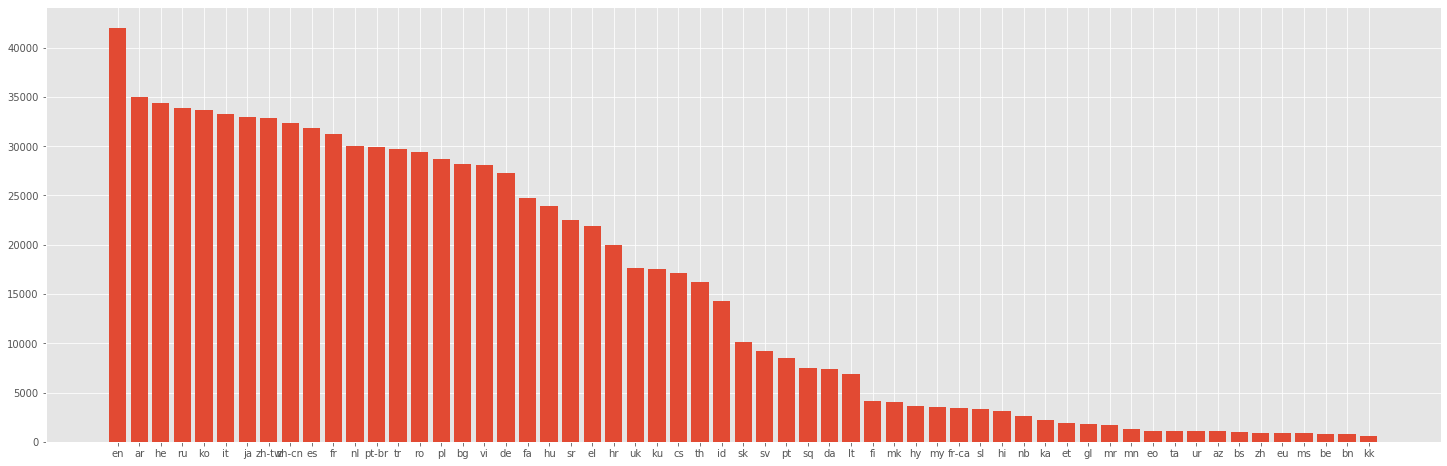

In [84]:
lang_count = (
    df_train_clear.language.value_counts()
    .to_frame()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(25,8))
ax.bar(lang_count['index'], lang_count['language'])

### Какие токены встречаются во всех языках
Во всех языках встречаются знаки препинания

In [7]:
sentence = df_train_clear['sentence'][70]
print(sentence)
print(nltk.tokenize.casual_tokenize(sentence))

Primul e , imaginaţi-vă că mergeţi la un investitor de risc mare şi spuneţi , &quot; &quot; Am o idee fantastică .
['Primul', 'e', ',', 'imaginaţi-vă', 'că', 'mergeţi', 'la', 'un', 'investitor', 'de', 'risc', 'mare', 'şi', 'spuneţi', ',', '"', '"', 'Am', 'o', 'idee', 'fantastică', '.']


In [13]:
occurence_language = {}

for language in tqdm_notebook(set(df_train_clear['language'])):
    occurence = Counter()
    for sentence in df_train_clear[df_train_clear['language'] == language]['sentence']:
        for token in nltk.tokenize.casual_tokenize(sentence):
            occurence[token] += 1
    occurence_language[language] = occurence

In [29]:
common_token = set(occurence_language['ru'].keys())
for language in tqdm_notebook(set(df_train_clear['language'])):
    common_token = common_token.intersection(set(occurence_language[language].keys()))
common_token

{'"', '(', ')', ',', '-', '.', ':'}

### Коллокации
Сначала нужно очистить текст от знаков препинания

In [13]:
def preprocessor(text):
    text = text.replace('&quot',' ')
    text = text.replace('&apos'," ")
    whitespaced_text = re.sub("[ —!#$&%\()*+,-./:;<=>?@[\\]^_`{|}~»♫1234567890 ]", " ", text.lower())
    return re.sub(' +', ' ',  whitespaced_text)

In [124]:
cooccurence_language = {}

for language in ['ru', 'en', 'de']:
    cooccurence = Counter()
    troccurence = Counter()
    teoccurence = Counter()
    for sentence in tqdm_notebook(df_train_clear[df_train_clear['language'] == language]['sentence']):
        token = nltk.tokenize.casual_tokenize(preprocessor(sentence))
        for i in range(len(token) - 3):
            cooccurence[(token[i], token[i+1])] += 1
            troccurence[(token[i], token[i+1], token[i+2])] += 1
            teoccurence[(token[i], token[i+1], token[i+2], token[i+3])] += 1
    cooccurence_language[language] = [cooccurence, troccurence, teoccurence]

Коллокации в основном состоят из сочетаний слов с местоимениями и словосочетаний, соединяющих сложные предложения в языке.

In [125]:
df_show = pd.DataFrame()
for language in ['ru', 'en', 'de']: 
    most_common_leng = cooccurence_language[language][0].most_common(50)
    df_show[language + "2"] = [most_common_leng[k][0][0] + " " + most_common_leng[k][0][1] for k in range(50)]
    most_common_leng = cooccurence_language[language][1].most_common(50)
    df_show[language + "3"] = [most_common_leng[k][0][0] + " " + most_common_leng[k][0][1] + " " + \
                               most_common_leng[k][0][2] for k in range(50)]
    most_common_leng = cooccurence_language[language][2].most_common(50)
    df_show[language + "4"] = [most_common_leng[k][0][0] + " " + most_common_leng[k][0][1] + " " + \
                               most_common_leng[k][0][2] + " " + most_common_leng[k][0][3]for k in range(50)]
df_show

,ru2,ru3,ru4,en2,en3,en4,de2,de3,de4
0,потому что,в том что,в то же время,it s,a lot of,i m going to,das ist,und das ist,stellen sie sich vor
1,то что,на самом деле,я имею в виду,of the,it s a,we re going to,in der,das ist ein,in den letzten jahren
2,и я,о том что,в том что мы,in the,and it s,thank you very much,es ist,es ist ein,auf der ganzen welt
3,что мы,у нас есть,в то время как,and i,one of the,i don t know,und ich,es ist eine,überall auf der welt
4,том что,о том как,проблема в том что,this is,this is a,to be able to,und das,das ist eine,das ist es was
5,в том,я думаю что,несмотря на то что,that s,i don t,i d like to,in den,das ist die,und das ist die
6,что я,для того чтобы,состоит в том что,and the,it s not,you re going to,und die,und es ist,vor ein paar jahren
7,у нас,то что мы,заключается в том что,i m,i m going,in the united states,und sie,stellen sie sich,ich denke das ist
8,и это,это то что,дело в том что,going to,i want to,at the same time,ist ein,das ist der,in den vereinigten staaten
9,я не,так же как,до тех пор пока,don t,m going to,it s going to,wenn sie,in den letzten,meine damen und herren


## word2vec

In [10]:
stop_words_languages = {'ar': 'arabic',
                        'az': 'azerbaijani',
                        'da': 'danish',
                        'nl': 'dutch',
                        'en': 'english',
                        'fi': 'finnish',
                        'fr': 'french',
                        'de': 'german',
                        'el': 'greek',
                        'hu': 'hungarian',
                        'id': 'indonesian',
                        'it': 'italian',
                        'kk': 'kazakh',
                        'nb': 'norwegian',
                        'pt': 'portuguese',
                        'ro': 'romanian',
                        'ru': 'russian',
                        'sl': 'slovene',
                        'es': 'spanish',
                        'sv': 'swedish',
                        'tr': 'turkish'}

In [168]:
def prepare_sentence_dataset(text, languages):
    tokenized_sentences = []
    for temp in tqdm_notebook(range(len(languages))):
        language = languages[temp]
        sentence = text[temp]
        if language in stop_words_languages.keys():
            stopword_set = set(nltk.corpus.stopwords.words(stop_words_languages[language]))
        else:
            stopword_set = set()
        tokenized_sentences.append(
            [token for token in nltk.tokenize.casual_tokenize(preprocessor(sentence)) if token not in stopword_set]
        )
    return tokenized_sentences

In [228]:
def embed_text(sentence, word2index, word_embeddings):
    stopword_set = set()
    array = [word_embeddings[word2index[word]] for word in sentence 
             if word in word2index and word not in stopword_set]    
    if array:
        return np.array(array).mean(0, keepdims=True)
    else: 
        return np.array([np.zeros(100)])

In [170]:
corpus   = df_train_clear['sentence']
language = df_train_clear['language']
sentence_dataset = prepare_sentence_dataset(corpus, language)

In [173]:
word2vec = gensim.models.Word2Vec(size=100, sg=0, window=5, min_count=30, negative=20)
word2vec.build_vocab(sentence_dataset)
word2vec.train(sentence_dataset, total_examples=word2vec.corpus_count, epochs=30)

(220541164, 330931110)

In [230]:
index2word = np.array(word2vec.wv.index2word)
embeddings = word2vec.wv.vectors
word2index = {word: i for i, word in enumerate(index2word)}
talk2vec = np.concatenate([embed_text(sentence, word2index, embeddings)  for sentence in tqdm_notebook(sentence_dataset)])

Посмотрим на похожие векторы

In [296]:
talk2vec_test = talk2vec[:10_000]

In [297]:
normed_talk2vec = normalize(talk2vec_test)
similarities = normed_talk2vec @ normed_talk2vec.T

In [298]:
threshold = 0.9

count = 0
i = 10
for j in range(similarities.shape[1]):
    if j > i:
        if similarities[i, j] > threshold:
            print(f"({i}, {j}) {similarities[i, j]:.2f}")
            count += 1

(10, 135) 0.93
(10, 221) 0.92
(10, 593) 0.92
(10, 596) 0.93
(10, 1840) 0.91
(10, 1874) 0.92
(10, 1904) 0.94
(10, 2559) 0.91
(10, 2675) 0.91
(10, 2838) 0.90
(10, 2888) 0.92
(10, 3128) 0.92
(10, 3688) 0.94
(10, 5117) 0.90
(10, 5692) 0.91
(10, 5869) 0.92
(10, 5914) 0.91
(10, 6225) 0.94
(10, 6789) 0.90
(10, 7092) 0.91
(10, 8039) 0.91
(10, 8336) 0.93
(10, 8491) 0.92
(10, 9119) 0.92
(10, 9667) 0.92
(10, 9700) 0.91
(10, 9715) 0.91


In [289]:
df_train_clear['sentence'][10]

'После увольнения я решил собрать своих друзей , чтобы высказаться о насилии в стране , высказаться о состоянии нации , и 1 июня 2009 года мы собирались пойти на стадион и попытаться привлечь внимание президента .'

In [299]:
df_train_clear['sentence'][9119]

'Общее количество вызванных человеком глобальных загрязнений в атмосфере на данный момент задерживает столько же тепловой энергии , сколько скопилось бы от взрывов 400 000 атомных бомб , как в Хиросиме , каждые сутки 365 дней в году .'

In [300]:
threshold = 0.7

count = 0
i = 42
for j in range(similarities.shape[1]):
    if j > i:
        if similarities[i, j] > threshold:
            print(f"({i}, {j}) {similarities[i, j]:.2f}")
            count += 1

(42, 71) 0.76
(42, 1004) 0.71
(42, 1300) 0.72
(42, 2143) 0.74
(42, 3007) 0.81
(42, 3495) 0.71
(42, 3524) 0.80
(42, 4925) 0.82
(42, 5612) 0.74
(42, 5714) 0.85
(42, 6715) 0.80
(42, 8300) 0.85
(42, 8579) 0.76
(42, 9517) 0.81


In [301]:
df_train_clear['sentence'][42]

'Si todos sus autos robots están rastreando las trayectorias predecidas , no se presta demasiada atención a esos paquetes .'

In [304]:
df_train_clear['sentence'][3495]

'Si consideramos rescate desde una perpectiva gráfica , lo que vemos al amontonar los billetes es , primero , 360 mil dólares es aproximadamente del tamaño de un individuo de 1,60 m .'

Разобьем пространство полученных векторов на кластеры. Данных много, поэтому возьмем быстрый kmeans.

In [391]:
cluster_model = KMeans(n_clusters = 60, random_state = 42)
markers = cluster_model.fit_predict(talk2vec)

In [392]:
df_train_clear['class'] = markers
df_train_clear

,sentence,language,class
0,"Pensez à la communication , le discours , les ...",fr,13
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs,56
2,"Každý starosta pochopil , že když mají tyto fo...",cs,56
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv,29
4,كان الأمر لا يصدق .,ar,1
...,...,...,...
897097,"E eu disse , de jeito nenhum , não vou estudar...",pt-br,52
897098,Så hvis du er liberal vil du sige . &quot; &qu...,da,29
897099,Я почав свою подорож 30 років тому .,uk,15
897100,数学的に表現するとこうなります もしあなたが 今日の社会を憂慮しているなら 数学的な関数の値...,ja,3


В целом, качество кластеризации не очень хорошее, но на некоторых языках классы определяются почти без шума

In [393]:
from sklearn import metrics

ll = list(set(df_train_clear['language']))
dictionary   = dict(zip(ll , np.arange(59)))
markers_true = [dictionary[df_train_clear['language'][k]] for k in range(df_train_clear.shape[0])]
score = metrics.adjusted_rand_score(markers_true, markers)

score

0.6839287677836151

In [397]:
print('language: th')
print("\n'class' value counts:")
print (df_train_clear[df_train_clear['language'] == 'th']['class'].value_counts()[:10])
print("\n'language' value counts:")
print (df_train_clear[df_train_clear['class'] == 11]['language'].value_counts()[:10])

print('\n\nlanguage: ja')
print("\n'class' value counts:")
print (df_train_clear[df_train_clear['language'] == 'ja']['class'].value_counts()[:10])
print("\n'language' value counts:")
print (df_train_clear[df_train_clear['class'] == 3]['language'].value_counts()[:10])

language: th

'class' value counts:
11    16163
3        20
46        2
34        1
Name: class, dtype: int64

'language' value counts:
th    16163
ru        1
lt        1
nb        1
en        1
cs        1
he        1
es        1
Name: language, dtype: int64


language: ja

'class' value counts:
3     20582
44     6695
49     2122
54     1329
9      1194
55      642
57      238
46      140
17       14
34        9
Name: class, dtype: int64

'language' value counts:
ja       20582
zh-tw     7768
zh-cn     6162
fi        3598
hu        3193
ru        1900
id        1735
ro        1704
de        1538
sl        1369
Name: language, dtype: int64


In [450]:
#df_train_clear.to_csv('nlp_train.csv')

## confusion_matrix

In [22]:
from sklearn.metrics import balanced_accuracy_score

In [11]:
stop_words = set() 
for stop_words_language in stop_words_languages.values():
    subset = set(nltk.corpus.stopwords.words(stop_words_language))
    stop_words = stop_words.union( subset )

In [14]:
vectorizer =  TfidfVectorizer(
              lowercase=True, ngram_range=(2,3), analyzer='char',
              stop_words = stop_words,
              preprocessor=preprocessor, min_df=15, max_df=0.8)
text = df_train_clear['sentence']
text_vect = vectorizer.fit_transform(text)

In [15]:
df_test   = pd.read_csv('nlp_check.csv')
text_test = df_test['sentence']
text_test_vect = vectorizer.transform(text_test)

In [20]:
ll = ['fr', 'gl', 'th', 'tr', 'pt', 'ka', 'eo', 'bn', 'ro', 'en', 'bg', 'mn', 'mk', 'ar', 'hy', 'cs', 'ru', 'sl', 'et', 'da', 'fi', 'fr-ca', 'hu', 'es', 'ur', 'sk',
      'he', 'sq', 'zh-tw', 'bs', 'de', 'uk', 'mr', 'sr', 'id', 'el', 'ja', 'sv', 'nl', 'fa', 'ta', 'nb', 'hr', 'lt', 'ms', 'ko', 'it', 'zh', 'my', 'pl', 'vi', 'be', 
      'kk', 'hi', 'az', 'ku', 'pt-br', 'eu', 'zh-cn']
dictionary   = dict(zip(ll , np.arange(59)))
y_train = [dictionary[df_train_clear['language'][k]] for k in range(df_train_clear.shape[0])]
y_test  = [dictionary[df_test ['language'][k]] for k in range(df_test.shape[0])]

In [16]:
from sklearn.linear_model import LogisticRegression

In [21]:
classificator = LogisticRegression(solver = 'liblinear')
classificator.fit(text_vect, y_train)
y_train_pred = classificator.predict(text_vect)
y_test_pred =  classificator.predict(text_test_vect)

In [23]:
print("Train:")
print(balanced_accuracy_score(y_train_pred, y_train))
print("Test:")
print(balanced_accuracy_score(y_test_pred, y_test))

Train:
0.968051788878899
Test:
0.9598525540331001


Выведем confusion_matrix целиком и кусочки матрицы вокруг диагонали для наглядности.

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

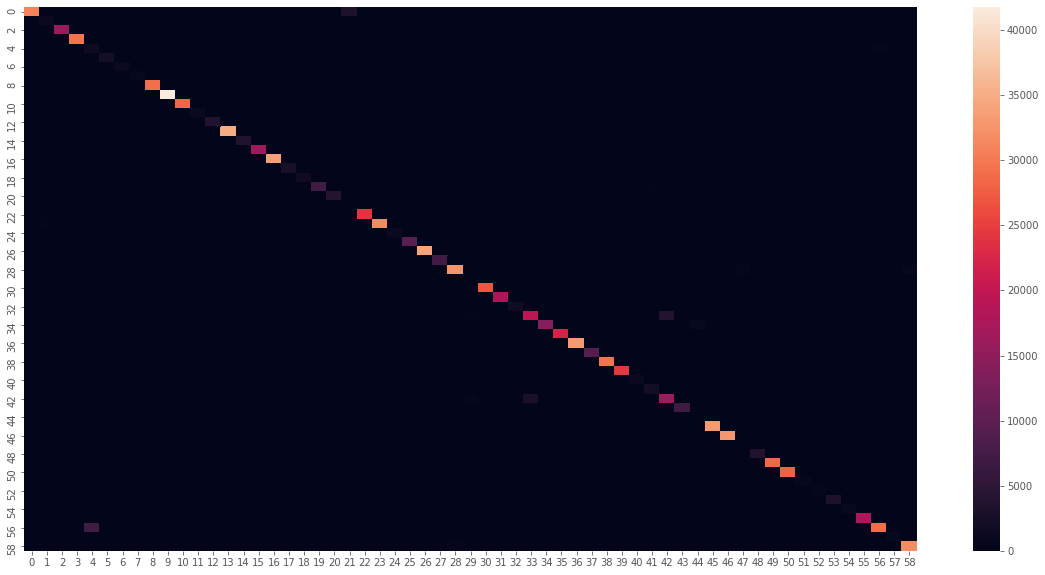

In [64]:
df_cm = pd.DataFrame(confusion_matrix(y_test_pred, y_test))
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=False)

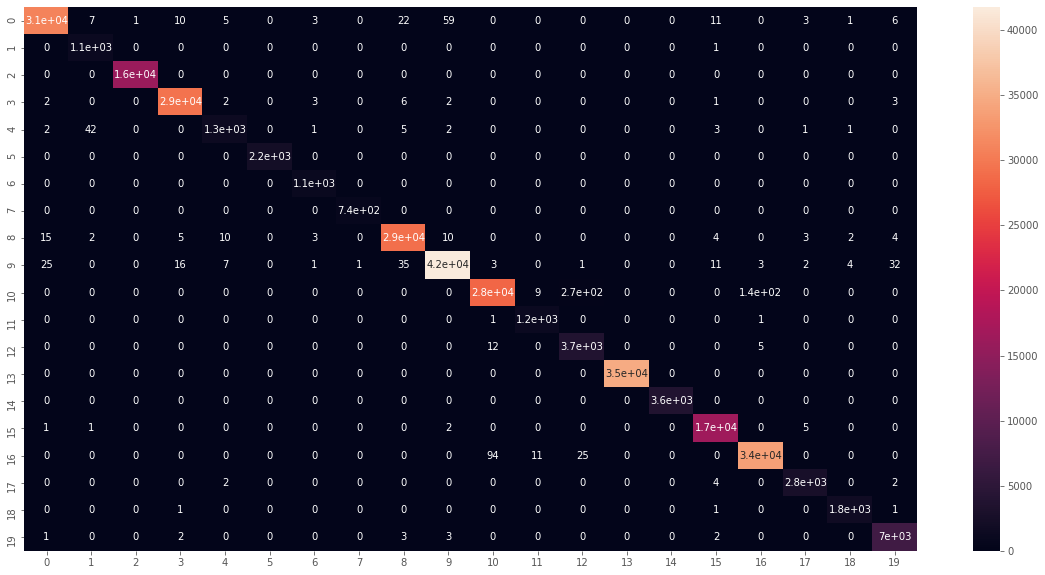

In [61]:
df_cm = pd.DataFrame(confusion_matrix(y_test_pred, y_test)[:20,:20])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

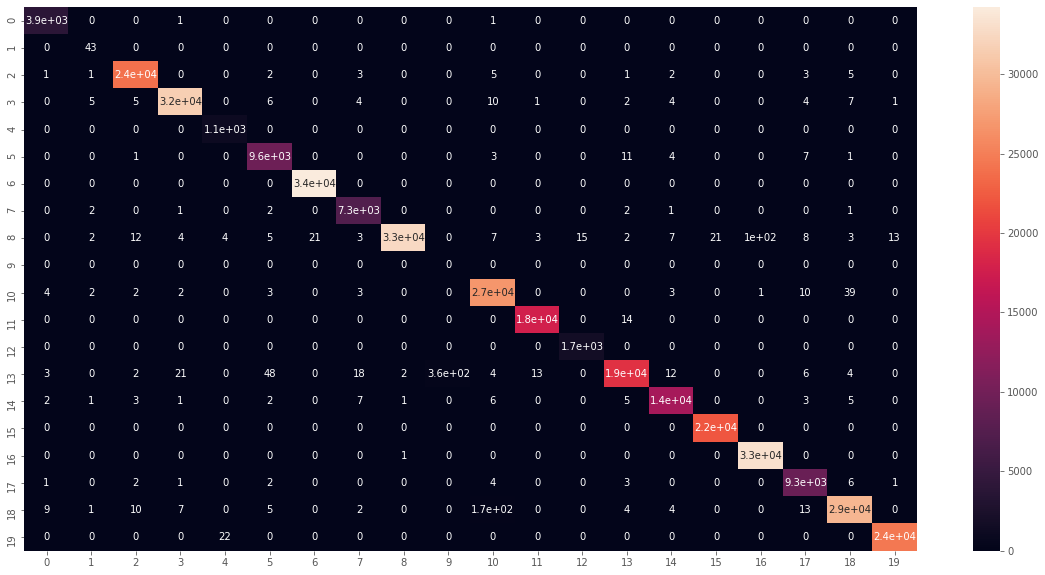

In [62]:
df_cm = pd.DataFrame(confusion_matrix(y_test_pred, y_test)[20:40,20:40])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

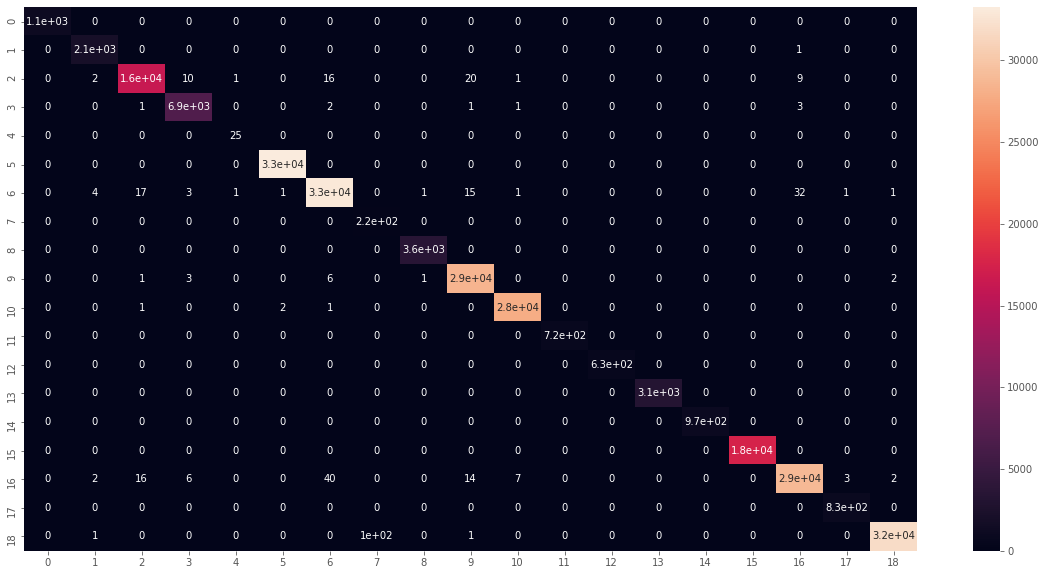

In [63]:
df_cm = pd.DataFrame(confusion_matrix(y_test_pred, y_test)[40:,40:])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In [81]:
redictionary = dict(zip(dictionary.values(), dictionary.keys()))
confmatr = confusion_matrix(y_test_pred, y_test)
prediction_err = {}
for i in tqdm_notebook(range(59)):
    size = len(df_test[df_test['language'] == redictionary[i]]['language'])
    for j in range(59):
        if not i == j and confmatr[i][j]/size > 1e-2:
            prediction_err[(redictionary[i], redictionary[j])] = confmatr[i][j]/size

In [82]:
sorted_prediction_err = sorted(prediction_err.items(), key=lambda kv: kv[1])
sorted_prediction_err

[(('hr', 'sl'), 0.010168650793650794),
 (('es', 'gl'), 0.010806577916992952),
 (('sk', 'cs'), 0.011760015945784333),
 (('sr', 'sl'), 0.012211308733740376),
 (('zh-cn', 'zh-tw'), 0.015392177947095149),
 (('cs', 'sk'), 0.015863585051393264),
 (('sr', 'bs'), 0.01601628174497832),
 (('zh-tw', 'zh'), 0.018689327728551124),
 (('nb', 'da'), 0.020563594821020565),
 (('zh-tw', 'zh-cn'), 0.021441316115764962),
 (('fr-ca', 'fr'), 0.0226928895612708),
 (('hr', 'bs'), 0.02941468253968254),
 (('da', 'nb'), 0.05616740088105727),
 (('id', 'ms'), 0.05978832270274059),
 (('pt', 'pt-br'), 0.06998372471518252),
 (('fr', 'fr-ca'), 0.10393736161473542),
 (('hr', 'sr'), 0.14146825396825397),
 (('sr', 'hr'), 0.16671091053889037),
 (('pt-br', 'pt'), 0.23744916327755183)]

Чаще всего модель путает язык и его наречие.

In [85]:
df_train_clear[df_train_clear['language'] == 'pt']['sentence'][:10]

465     Dei-lhe medicamentos que chamamos de diurético...
678     É da mesma idade , mas não está no lar de terc...
889                     Então é um cometa muito recente .
911        MR : Bem , penso que muita coisa não é minha .
1191    Depois , a próxima coisa que fazemos é desenha...
1314        Continuo a pensar nestes rapazes sem braços .
1343    Precisamos de estrategistas tecnológicos na di...
1436    A empatia aparece cedo na vida , talvez ainda ...
1635                                        Levantem-no .
1720    Eles criaram esta coisa chamada caixa de facto...
Name: sentence, dtype: object

In [86]:
df_train_clear[df_train_clear['language'] == 'pt-br']['sentence'][:10]

75     &quot; &quot; Meu mundo &quot; &quot; nos diz ...
94     Não penso que receber ou não elogios deveria s...
95     cientistas nos dizem — e eles estão só chutand...
111    Muito pequeno para ser detectado , sua proteçã...
145    E essa conjuntura é importante , hoje , nesse ...
189    E muitas pessoas diziam que não poderia . E ac...
203    Como já disse , inclusive o prédio em que esta...
205    Mark Granovetter , sociólogo de Stanford , em ...
224                             Podemos entrar na água .
261    Eu realmente deveria agradecer a Deus por esta...
Name: sentence, dtype: object

Распределение по классам (кластеризация) немного отличается

In [87]:
print(df_test[df_test['language'] == 'pt']['class'].value_counts()[:10])
print(df_test[df_test['language'] == 'pt-br']['class'].value_counts()[:10])

8     7246
52     613
3      356
42     224
46     130
22       8
34       7
17       4
0        3
21       2
Name: class, dtype: int64
52    26998
8      2694
50      159
3        79
46       40
42       14
34        3
38        2
6         2
17        2
Name: class, dtype: int64


In [142]:
markers_train = pd.read_csv('nlp_train.csv', usecols = ['class'])
markers_train['prediction'] = y_train_pred
markers_test = pd.read_csv('nlp_check.csv', usecols = ['class'])
markers_test['prediction'] = y_test_pred

In [136]:
from sklearn.tree import DecisionTreeClassifier

In [147]:
#classificator2 = DecisionTreeClassifier(random_state = 42)
#parameters = {
#    'max_depth': (None, 1,2,3,4,5,6,7,8,9,10),
#    'min_samples_leaf': (None, 1,2,3,4,5,6,7,8,9,10)
#}
#grid_search = GridSearchCV(classificator2, parameters, cv=5, n_jobs=18, scoring='balanced_accuracy', verbose=1)
#grid_search.fit(markers_train, y_train)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.5s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:  3.8min
[Parallel(n_jobs=18)]: Done 414 tasks      | elapsed:  9.4min
[Parallel(n_jobs=18)]: Done 605 out of 605 | elapsed: 13.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=18,
             param_grid={'max_depth': (None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
     

In [152]:
classificator2 = DecisionTreeClassifier(random_state = 42)
classificator2.fit(markers_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [153]:
print("Train:")
print(balanced_accuracy_score(classificator2.predict(markers_train), y_train))
print("Test:")
print(balanced_accuracy_score(classificator2.predict(markers_test), y_test))

Train:
0.9727697183349734
Test:
0.966678350846632


## Токены с максимальной важностью

# Часть 2
## Подготовка контрольной выборки

In [442]:
df_test = pd.read_csv("./data/task7/train.csv", skiprows = range(1,2_000_000), nrows = 1_000_000)
df_test

,sentence,language
0,كانوا مضطرين إلى التوقف عند جزيرة كاتالينا بعد...,ar
1,"제가 물었습니다 , “ 제가 나이가 들고 털들이 하얘지면",ko
2,これは 本当に 手こずったよ,ja
3,"Για να το πετύχουμε αυτό , εμείς και οι πελάτε...",el
4,"Во ваков случај , при ваква измама , дозволува...",mk
...,...,...
999995,อย ่ างแน ่ นอนที ่ สุดที ่ อุโมงค ์ ลม ที ่ เ...,th
999996,Visas kylančios ekonomikos prisijungia prie Va...,lt
999997,Како си остварио обе ствари ?,sr
999998,гэта што калі мы не яны як але ён каб дзякуй б...,ru


In [443]:
df_clear = df_test.loc[~df_test['sentence'].isin(errors)]
sentences = np.array(df_clear['sentence'])
languages = np.array(df_clear['language'])

df_test_clear = pd.DataFrame()
df_test_clear['sentence'] = sentences
df_test_clear['language'] = languages
df_test_clear

,sentence,language
0,كانوا مضطرين إلى التوقف عند جزيرة كاتالينا بعد...,ar
1,"제가 물었습니다 , “ 제가 나이가 들고 털들이 하얘지면",ko
2,これは 本当に 手こずったよ,ja
3,"Για να το πετύχουμε αυτό , εμείς και οι πελάτε...",el
4,"Во ваков случај , при ваква измама , дозволува...",mk
...,...,...
897143,All the way back into early philosophy and cer...,en
897144,"Tisućama je puta , možda 3.000 puta čvršća od ...",hr
897145,อย ่ างแน ่ นอนที ่ สุดที ่ อุโมงค ์ ลม ที ่ เ...,th
897146,Visas kylančios ekonomikos prisijungia prie Va...,lt


In [444]:
corpus   = df_test_clear['sentence']
language = df_test_clear['language']
sentence_dataset = prepare_sentence_dataset(corpus, language)

In [445]:
talk2vec = np.concatenate([embed_text(sentence, word2index, embeddings)  for sentence in tqdm_notebook(sentence_dataset)])

In [446]:
markers = cluster_model.predict(talk2vec)

In [449]:
df_test_clear['class'] = markers
#df_test_clear.to_csv('nlp_check.csv')
df_test_clear

,sentence,language,class
0,كانوا مضطرين إلى التوقف عند جزيرة كاتالينا بعد...,ar,37
1,"제가 물었습니다 , “ 제가 나이가 들고 털들이 하얘지면",ko,31
2,これは 本当に 手こずったよ,ja,44
3,"Για να το πετύχουμε αυτό , εμείς και οι πελάτε...",el,30
4,"Во ваков случај , при ваква измама , дозволува...",mk,27
...,...,...,...
897143,All the way back into early philosophy and cer...,en,17
897144,"Tisućama je puta , možda 3.000 puta čvršća od ...",hr,58
897145,อย ่ างแน ่ นอนที ่ สุดที ่ อุโมงค ์ ลม ที ่ เ...,th,11
897146,Visas kylančios ekonomikos prisijungia prie Va...,lt,33


## Подготовка тестовой выборки

In [3]:
df_test = pd.read_csv("./data/task7/test.csv")
df_test_clear = df_test

In [457]:
def prepare_sentence_dataset_test(text):
    tokenized_sentences = []
    for temp in tqdm_notebook(range(len(text))):
        sentence = text[temp]
        stopword_set = stop_words
        tokenized_sentences.append(
            [token for token in nltk.tokenize.casual_tokenize(preprocessor(sentence)) if token not in stopword_set]
        )
    return tokenized_sentences

In [459]:
corpus   = df_test_clear['sentence']
sentence_dataset = prepare_sentence_dataset_test(corpus)

In [460]:
talk2vec = np.concatenate([embed_text(sentence, word2index, embeddings)  for sentence in tqdm_notebook(sentence_dataset)])

In [463]:
markers = cluster_model.predict(talk2vec)

In [465]:
df_test_clear['class'] = markers
#df_test_clear.to_csv('nlp_test.csv')
df_test_clear

,index,sentence,class
0,0,תודה לכם .,43
1,1,"Precisamos de compaixão para começar , e auto-...",8
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,55
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,31
4,4,これをロボットに組み込みました,3
...,...,...,...
2784629,2784629,"Kako bilo , upravo tada se pojavio jedan autor...",6
2784630,2784630,Y la pequeña victoria que siento cuando lo hag...,21
2784631,2784631,Prečo ? Lebo je to v každom z nás .,26
2784632,2784632,IBM과 USDA과 같이 하고 있습니다 . 이를 저작권 보호가 없는 퍼블릭 도메인에...,31


## Модель

In [154]:
df_test = pd.read_csv("nlp_test.csv")

In [155]:
text_test = df_test['sentence']
text_test_vect = vectorizer.transform(text_test)

In [156]:
y_test_pred =  classificator.predict(text_test_vect)

In [168]:
submission_df = pd.DataFrame()
#y_test_pred_lang = [redictionary[y_test_pred[k]] for k in range(len(y_test_pred))]
submission_df['index'] = np.arange(2784634)
submission_df['language'] = y_test_pred_lang
submission_df.to_csv('Submition1.csv', index = False)

In [170]:
markers_test = pd.read_csv('nlp_test.csv', usecols = ['class'])
markers_test['prediction'] = y_test_pred

In [171]:
y_test_pred2 = classificator2.predict(markers_test)

In [177]:
submission_df = pd.DataFrame()
y_test_pred_lang2 = [redictionary[y_test_pred2[k]] for k in range(len(y_test_pred))]
submission_df['index'] = np.arange(2784634)
submission_df['language'] = y_test_pred_lang2
submission_df.to_csv('Submition2.csv', index = False)